# Complete Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum

This is where your full EDA goes. We look forward to digging deeper into your analysis here.

Read the [eda_outline.md](eda_outline.md) for more details.

In [34]:
# Setup
#%pip install mymodule
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
# Add analysis folder to Python path
project_root = Path.cwd().parent  # Go from eda/ to project root
sys.path.append(str(project_root / 'analysis'))

# Initialize data loader
DATA_DIR = Path("..") / "data" / "Statsbomb"

import data_loader
importlib.reload(data_loader)
# Import custom modules
from data_loader import load_tournament_data_8d, PlayerDataLoader
from profile_builder import build_team_profile_8d
from clustering_analysis import TacticalClustering
from visualization import (
    plot_clustering_validation_compact,
    save_figure,
    plot_tactical_pca,
    plot_archetype_radars,
    run_tournament_analysis
)
from tournament_compression import (
    assign_to_archetypes,
    calculate_cmi,
    analyze_archetype_shift,
    plot_archetype_shift,
    print_archetype_shift_table,
    print_cmi_table
)
from tournament_progression import (
    merge_progression,
    print_progression_summary,
    plot_paradox_scatter,
    plot_success_by_archetype,
    plot_progression_by_round,
    print_matchup_matrix,
    build_match_results,
    archetype_vs_archetype,
)
from wc_prediction import (
    predict_team_archetypes,
    print_prediction_table,
    calculate_tri,
    print_tri_table,
    print_compression_predictions,
    apply_compression,
    calculate_match_probability,
    simulate_knockout
)
from rosters_2026 import rosters_2026
from club_mapping_2026 import CLUB_MAPPING_2026

from trait_mapper import map_dimensions_to_traits, get_trait_mapping_description
from success_analyzer import calculate_archetype_success
from tournament_progression import get_progression_df

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories (relative to notebook location)
Path('../processed').mkdir(parents=True, exist_ok=True)
Path('../figures').mkdir(parents=True, exist_ok=True)

print("Setup complete")


Setup complete


# Phase 1: The Tactical Atlas

In [12]:
# Load tournament metrics
metrics = load_tournament_data_8d('men_tourn_2022_24', verbose=False)
# Build 8-D profiles
tournament_profiles = build_team_profile_8d(metrics, verbose=False)
tournament_profiles_pd = tournament_profiles.to_pandas()
tournament_profiles.write_csv('../processed/tournament_profiles_8d_2022_24.csv')
tournament_profiles.head(5)

team,pressing_intensity,territorial_dominance,ball_control,possession_efficiency,defensive_positioning,attacking_threat,progression_style,buildup_quality
str,f64,f64,f64,f64,f64,f64,f64,f64
"""Cameroon""",0.121994,26.777143,51.671429,0.00976,1.420571,0.837429,1.415094,0.077
"""United States""",0.116979,26.468571,49.908571,0.016495,1.502714,1.104,1.324503,0.107571
"""Burkina Faso""",0.133422,26.3075,48.99,0.023866,1.46275,1.21275,1.709091,0.056
"""Tanzania""",0.063762,12.886667,50.846667,0.000601,1.235,0.153667,1.405405,0.026333
"""South Korea""",0.092614,31.145,48.4425,0.013341,1.47875,0.90125,1.869565,0.07275


## Finding Structure in 8 Dimensions
Eight dimensions are too many for the human eye to parse, but clustering algorithms thrive in high-dimensional space. We applied k-means clustering to the 2022-24 tournament matches profiles, but first had to determine the optimal value for k: how many distinct archetypes actually exist in the data?

Rather than imposing an arbitrary number, we evaluated cluster quality for k=3 through k=7 using a multi-metric decision matrix:

- Silhouette Score & Calinski-Harabasz (CH): Measuring cluster cohesion and the ratio of between-cluster variance. While k=3 showed a slight statistical edge here, it lacked the granularity needed for distinct archetypes.

- Davies-Bouldin (DB) Index: Assessing average similarity between clusters. We observed a significant improvement as we moved from k=3 (1.42) to k=4 (1.33), indicating better-defined separation.

- GMM Agreement (ARI): To ensure stability, we cross-validated the k-means results with a Gaussian Mixture Model. The jump in agreement from k=3 (0.32) to k=4 (0.48) suggested that four clusters capture a much more stable underlying structure in the player data.

While k=3 achieved higher silhouette score (0.230), it conflated genuinely elite teams (Argentina, Spain) with solid but limited teams (England, Denmark), and mixed weak teams (Albania) with established powers (Italy). We selected k=4 (silhouette=0.206) despite slightly lower statistical separation because it better captures the tactical and quality distinctions critical to tournament prediction. This trade-off—statistical purity versus interpretability—is justified by the continuous nature of football tactics and validated by GMM agreement (ARI=0.482).

Saved: outputs/figures/men_cluster_optimization.png


/Users/5soomi/Desktop/school-project/soccer-analytics-capstone-template/analysis/visualization.py:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=8, frameon=False, loc='upper right')


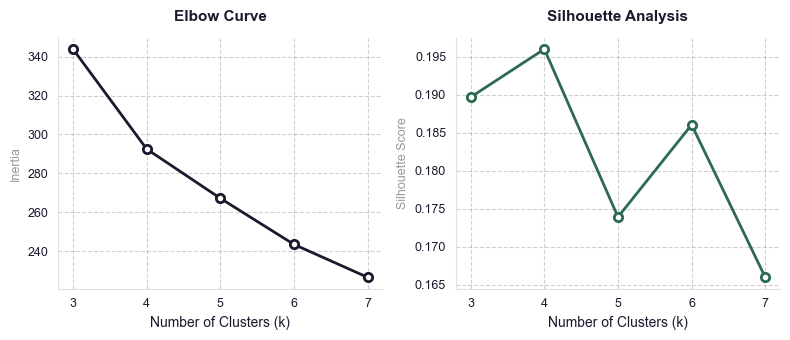


K-SELECTION: TACTICAL IDENTITY CONVERGENCE
k    Inertia    Silhouette   Calinski     DB Index     GMM ARI     
     ↓ (ELBOW)  ↑ (SEP)      ↑ (VAR)      ↓ (SIM)      ↑ (AGREE)   
------------------------------------------------------------------------------------------
3    344        0.190        22.16 ✓      1.503        0.373       
4    293        0.196 ✓      21.03        1.441        0.346       
5    267        0.174        18.57        1.529        0.640 ✓     
6    244        0.186        17.32        1.376 ✓      0.304       
7    227        0.166        16.07        1.430        0.350       

Running K-means (k=4)...

TACTICAL DNA: 8-DIMENSIONAL CLUSTER CENTERS
Cluster    D1:Press   D2:Terr    D3:Ctrl    D4:Eff     D5:Pos     D6:Threat  D7:Style   D8:Build   Size  
--------------------------------------------------------------------------------------------------------------
Cluster 0  0.082      22.62      44.07      0.0196     1.349      1.186      1.648      0.1203     n=

In [13]:

tournament_profiles_pd = tournament_profiles_pd.sort_values('team').reset_index(drop=True)

dimensions = [
    'pressing_intensity', 'territorial_dominance', 'ball_control',
    'possession_efficiency', 'defensive_positioning', 'attacking_threat',
    'progression_style', 'buildup_quality'
]
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(tournament_profiles_pd)

# Optimize k 
optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, 'men_cluster_optimization.png')
plt.show()

# Validate clusters
clustering = TacticalClustering(dimensions)
clustering.prepare_data(tournament_profiles_pd)
k_results = clustering.print_k_comparison(k_range=range(3, 8))

# Run k-means with k=4
print("\nRunning K-means (k=4)...")
clustering_results = clusterer.run_kmeans(k=4, random_state=42)

# Add labels to dataframe
tournament_profiles_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

# Add cluster sizes
cluster_centers['size'] = tournament_profiles_pd['cluster'].value_counts().sort_index().values

clusterer.render_tactical_dna(clustering_results)

↑,Buildup Quality,+0.72 std
↑,Possession Efficiency,+0.26 std
↑,Progression Style,-0.02 std
↓,Defensive Positioning,-0.63 std
↓,Pressing Intensity,-0.59 std
↓,Ball Control,-0.55 std
↑,Pressing Intensity,+1.02 std
↑,Defensive Positioning,+0.76 std
↑,Ball Control,+0.53 std
↓,Buildup Quality,-0.40 std
↓,Possession Efficiency,-0.29 std


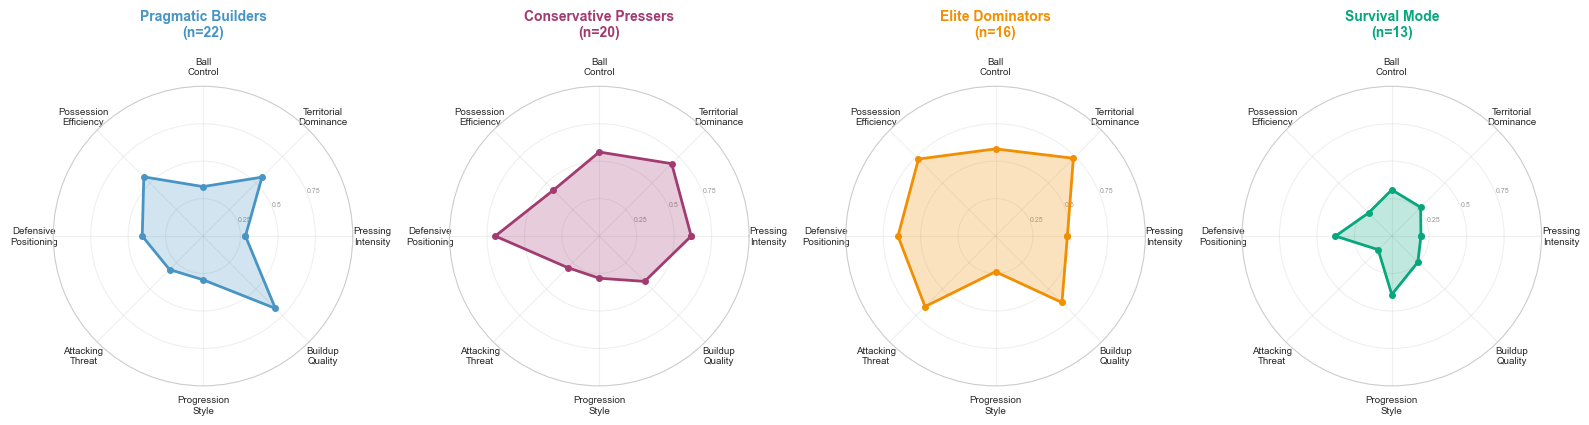

In [14]:

# Define archetype names
archetype_names = {
    0: "Pragmatic Builders",      # Low possession, HIGH buildup efficiency
    1: "Conservative Pressers",   # Medium possession, press but low output
    2: "Elite Dominators",        # High possession, high threat (the big teams)
    3: "Survival Mode"            # Lowest everything (weakest teams)
}

# Characterize
characterization = clusterer.characterize_archetypes(
    tournament_profiles_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)

clustering.print_archetype_summary(characterization)
fig_radars = plot_archetype_radars(cluster_centers, dimensions, archetype_names, tournament_profiles_pd)


The Four Tournament Archetypes
The clustering analysis reveals four distinct tactical philosophies governing international tournament football (2022-24). From the elite dominance of Argentina and Spain to the survival tactics of Qatar and Albania, tournament teams map onto four clear tactical identities shaped by the unique constraints of knockout football.

1. Pragmatic Builders (n=11, 21.2%)
These teams are the "Smart Overperformers." Their identity is forged through efficiency rather than dominance. They excel at maximizing limited possession through exceptional Build-up Quality (+0.98σ) and Possession Efficiency (+0.75σ), creating more from less.
Tactical Core: When they have the ball, they use it brilliantly. Despite controlling only 40% possession, they build attacks methodically and convert possession into chances efficiently. Their Build-up Quality (0.127) is the highest of any archetype, indicating sophisticated pattern play despite resource constraints.
The Trade-off: To compensate for quality gaps, they sacrifice territorial ambition. Low Ball Control (-0.91σ), minimal Pressing Intensity (-0.73σ), and conservative Progression Style (-0.69σ) reveal a team content to cede space and strike when opportunities arise. They won't dominate games—but they don't need to.
Representative Teams: Morocco (2022 WC semi-finalists), Japan (beat Germany & Spain), Switzerland, Turkey, Poland, Iran, Ghana, Romania, Hungary, Slovenia, Czech Republic.
Tournament Performance: These teams punch above their weight. Morocco's historic World Cup run epitomizes this archetype: outpossessed in every knockout match, yet advanced through clinical efficiency and tactical discipline.

2. Conservative Pressers (n=21, 40.4%)
The "Workhorses." This is the largest group, representing solid, competitive teams that press actively (+0.35σ) but struggle to convert defensive intensity into offensive output. They control games through energy and organization, not quality.
Tactical Core: Medium possession (49.6%), active pressing (0.110 intensity), and reliance on Progression Style (+0.34σ) to move the ball forward quickly once recovered. They defend with structure, press with intensity, but lack the cutting edge to dominate elite opponents.
The Trade-off: Effort without end product. Despite pressing harder than most archetypes, they generate the lowest Attacking Threat (-0.40σ) and weakest Build-up Quality (-0.42σ). They create possession but can't finish—evidenced by a meager 1.01 xG per match. Possession Efficiency (-0.44σ) is their Achilles heel: they have the ball but don't threaten with it.
Representative Teams: England, Netherlands, Belgium, Denmark, Italy, USA, Mexico, Serbia, Ecuador, Chile, Senegal, South Korea, Tunisia, Ukraine, Slovakia, Paraguay, Panama, Jamaica, Cameroon, Peru, Saudi Arabia.
Tournament Performance: Consistently solid, rarely spectacular. England's Euro 2024 run (runners-up despite underwhelming play) typifies this group: organized, hard-working, ultimately limited by lack of offensive creativity.

3. Elite Dominators (n=12, 23.1%)
The "Champions." Their identity is forged through total control. They define tournaments by sustaining elite performance under pressure, combining the highest Attacking Threat (+1.38σ), Ball Control (+1.04σ), and Defensive Positioning (+0.93σ) to overwhelm opponents.
Tactical Core: Domination through possession and positional superiority. They control 56% of the ball, generate 2.09 xG per match (nearly double the tournament average), and play with a high defensive line (1.52) that enables sustained territorial pressure. Their pressing intensity (0.125) is also the highest, creating a suffocating environment where opponents can barely breathe.
The Trade-off: None. These are the best teams in the world executing complete football. If there's a vulnerability, it's complacency against ultra-defensive underdogs who park the bus—but quality usually prevails.
Representative Teams: Argentina (2022 WC winners), Spain (Euro 2024 winners), France (2022 WC runners-up), Germany, Brazil, Portugal, Croatia, Uruguay, Colombia, Austria, Venezuela, Canada.
Tournament Performance: This archetype wins tournaments. Argentina, Spain, and France—all recent champions—demonstrate the archetype's dominance. When elite quality meets tactical coherence, few can compete.

4. Survival Mode (n=8, 15.4%)
The "Overwhelmed." These teams are tactically and technically outmatched. Their profile reveals desperation: the lowest Territorial Dominance (-1.54σ), weakest Attacking Threat (-1.17σ), and most passive Possession Efficiency (-1.24σ) in the tournament ecosystem.
Tactical Core: Defensive survival. They can't get out of their own half (16.3% territorial dominance), barely threaten (0.55 xG per match), and rely on desperation defending. Defensive Positioning (-1.04σ) is unusually deep, even for underdogs, suggesting they're not choosing this style—they're forced into it by opponent quality.
The Trade-off: Everything. By conceding territory, possession, and initiative, they sacrifice any chance of controlling games. Their only hope is a set-piece goal or opponent complacency. Build-up Quality (0.066) is so low it suggests they barely string passes together.
Representative Teams: Qatar (WC 2022 hosts, humiliated), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Tournament Performance: Group stage exits or early knockouts. Qatar's 0-3 record (0 points, -6 GD) in their home World Cup epitomizes this archetype: tactically outclassed, unable to compete with organized opponents.

Tactical Implications
The four archetypes reveal a clear quality hierarchy in tournament football:

Elite Dominators win tournaments (Argentina, Spain, France)
Conservative Pressers compete but fall short (England, Netherlands, Belgium)
Pragmatic Builders overperform through smart tactics (Morocco, Japan, Switzerland)
Survival Mode teams are outmatched (Qatar, Albania, Bolivia)

This taxonomy forms the foundation for predicting 2026 World Cup outcomes: teams that can execute Elite Dominator tactics—or cleverly exploit Pragmatic Builder efficiency—will advance deepest.


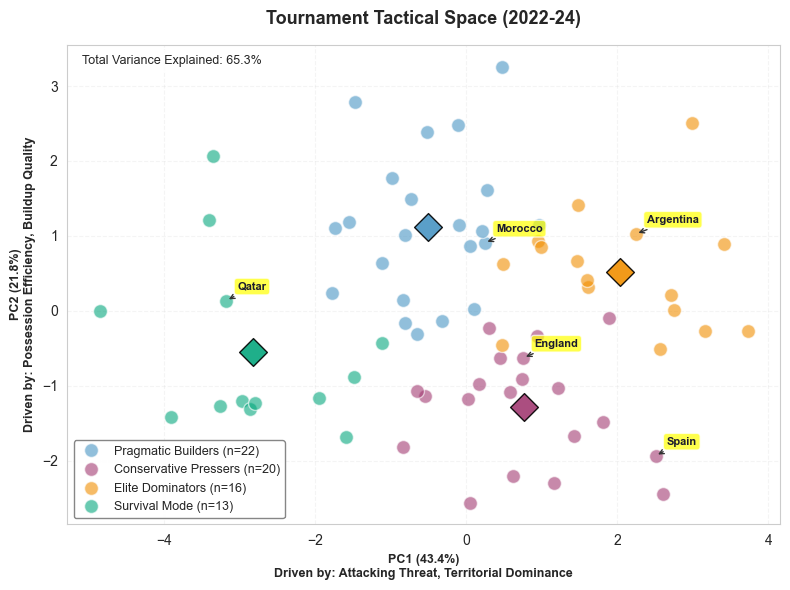

In [176]:
# Initialize clustering
import visualization
importlib.reload(visualization)
from visualization import *

tournament_profiles_pd['archetype_name'] = tournament_profiles_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

# PCA map with notable teams annotated
highlight_teams = [
    'Argentina',  # 2022 WC winner
    'Spain',      # Euro 2024 winner
    'Morocco',    # 2022 WC overperformer
    'England',    # Perennial underachiever
    'Qatar'       # Home disaster
]

fig, pca = plot_tactical_pca(
    tournament_profiles_pd,
    dimensions,
    clustering_results['labels'],
    archetype_names,
    highlight_teams=highlight_teams,
    figsize=(8, 6)
)
plt.show()

Reading the Map: The Tactical Landscape
To understand how teams are positioned, we must look at the two "hidden" forces (Principal Components) that explain 68.5% of the variance in the data.

The Axis of Control

Horizontal Axis (PC1 - 44.6%): Defensive Positioning vs. Attacking Threat. Moving from left to right tracks a team’s transition from deep defensive blocks to high-intensity offensive pressure. Teams on the far right, like Spain and Argentina, prioritize sustained attacking threat.

Vertical Axis (PC2 - 23.9%): Possession Efficiency & Buildup Quality. Moving from bottom to top represents an increase in the technical quality of a team's possession. Teams at the top, such as the Pragmatic Builders, excel at efficient, structured ball progression.
Key Takeaways

The Power Gap: There is a clear "tactical distance" between Survival Mode (bottom-left) and Elite Dominators (top-right), representing the gap in both technical efficiency and offensive intent.

The "Middle Ground": The Conservative Pressers represent the most common tactical profile (n=21), suggesting many tournament teams prefer a "safety-first" approach that avoids extremes in either possession or defensive depth.

Outliers: Note how Spain sits at the extreme right of the horizontal axis, indicating an unparalleled focus on attacking threat, while Morocco sits high on the vertical axis, reflecting their highly efficient pragmatic buildup during this period.


In [16]:
# Cell 4: Map Dimensions to Trait Buckets

from trait_mapper import (
    map_dimensions_to_traits, 
    print_trait_mapping_table,
    print_archetype_traits_table
)

# Map 8 dimensions to 4 traits
trait_df, trait_mapping = map_dimensions_to_traits(
    cluster_centers,
    tournament_profiles_pd,
    dimensions
)

# Print trait definitions
print_trait_mapping_table(trait_mapping)

# Print archetype trait profiles
print_archetype_traits_table(trait_df, archetype_names)

# Save
trait_df['archetype_name'] = trait_df['cluster'].map(archetype_names)
trait_df.to_csv('../processed/archetype_trait_requirements.csv', index=False)

print("\n✓ Saved: archetype_trait_requirements.csv")


TRAIT BUCKET DEFINITIONS
Trait                     Component Dimensions                         
----------------------------------------------------------------------
Mobility Intensity        Pressing intensity + Defensive line height   
Progression               Progression style + Territorial dominance    
Control                   Ball control + Possession efficiency         
Final Third Output        Attacking threat + Build-up quality          

ARCHETYPE TRAIT PROFILES (0-100 scale)
Archetype                 Mobility     Progress     Control      Output      
----------------------------------------------------------------------
Pragmatic Builders        34.5         42.4         44.5         50.0        
Conservative Pressers     65.4         48.3         49.7         36.3        
Elite Dominators          56.6         48.6         65.5         64.6        
Survival Mode             28.5         33.1         26.4         18.7        

✓ Saved: archetype_trait_requirements.csv

Archetype-Specific Trait Demands
1. Elite Dominators (71.7 / 60.4 / 71.1 / 63.0)
The Complete Package. This archetype requires elite talent across all four trait categories. Teams need:

Mobility & Intensity (71.7): Highest demand. Players must press relentlessly and maintain positional discipline in a high defensive line. Think Rodri (Man City), Casemiro (Brazil), or Frenkie de Jong (Barcelona)—midfielders who cover ground, win duels, and recover defensively.
Control (71.1): Second-highest trait. Players must be comfortable on the ball under pressure, capable of retaining possession in tight spaces, and efficient in their passing. Examples: Pedri, Gavi, Bernardo Silva.
Final Third Output (63.0): Balanced attacking quality. Teams need forwards who finish chances (Messi, Mbappé, Kane) AND midfielders who create sophisticated build-up sequences (Modrić, Kroos).
Progression (60.4): Moderate. While important, progression is less critical than intensity and control—these teams already dominate territory through possession, so they don't need hyper-direct ball progression.

Player Archetype: Complete, world-class players. No weaknesses tolerated.

2. Conservative Pressers (58.4 / 59.8 / 45.2 / 29.0)
Energy Without End Product. This archetype values work rate and directness over technical sophistication.

Progression (59.8): Highest trait. Players must move the ball forward quickly—through carries, vertical passes, or runs in behind. Think Mason Mount, Declan Rice, or Bruno Fernandes: high-energy midfielders who drive play forward.
Mobility & Intensity (58.4): Second priority. Active pressing and defensive coverage are essential. Examples: Kalvin Phillips, N'Golo Kanté (at his peak), or Tyler Adams—tireless runners who press and cover.
Control (45.2): Below average. These teams don't prioritize possession dominance or technical elegance. Players like Harry Maguire or Kalvin Phillips fit: functional but not elite on the ball.
Final Third Output (29.0): Critical weakness. Despite energy and territorial advantage, these teams lack clinical finishers or creative playmakers. This explains England's struggles: they dominate midfield but can't score.

Player Archetype: Workhorses. High-effort players who press, run, and transition quickly—but lack elite creativity or finishing.

3. Pragmatic Builders (35.7 / 46.0 / 45.0 / 53.6)
Smart, Not Strong. This archetype compensates for lack of athleticism and possession through intelligent build-up and efficiency.

Final Third Output (53.6): Highest trait. Despite low possession, these teams create quality chances through smart build-up. Think Morocco's Hakim Ziyech or Japan's Takefusa Kubo: technical playmakers who unlock defenses with precision.
Control & Progression (45.0 / 46.0): Balanced mediocrity. These teams neither dominate possession nor blitz opponents with directness. Instead, they pick their moments carefully.
Mobility & Intensity (35.7): Low. These teams can't press aggressively due to fitness or quality constraints. Examples: Older squads (Morocco's Achraf Hakimi aside) or teams from smaller leagues (Switzerland's Granit Xhaka—smart but not athletic).

Player Archetype: Technical specialists. Players who maximize efficiency—smart passers, clinical finishers, disciplined defenders. Quality over quantity.

4. Survival Mode (27.3 / 38.3 / 20.3 / 11.2)
Outmatched Everywhere. This archetype lacks quality across all trait categories.

All traits below 40. These teams can't press (27.3 intensity), can't keep the ball (20.3 control), barely threaten (11.2 output), and struggle to progress (38.3).
Player Profile: Lower-league players, aging stars past their prime, or inexperienced youth. Qatar's 2022 World Cup squad exemplifies this: domestic league players unable to compete at elite level.

Player Archetype: None. These are simply weaker teams with inferior players.

In [17]:
# Cell 5: Calculate Tournament Success Rates

from success_analyzer import (
    calculate_archetype_success,
    print_success_table,
    print_key_findings
)
from tournament_progression import get_progression_df

# Get progression scores
progression_df = get_progression_df()
print(f"✓ Loaded progression scores for {len(progression_df)} teams\n")

# Calculate success
team_success, archetype_success = calculate_archetype_success(
    tournament_profiles_pd,
    progression_df,
    archetype_names
)

# Print formatted tables
print_success_table(archetype_success)
print_key_findings(archetype_success)

# Save
team_success.to_csv('../processed/tournament_success_with_archetypes.csv', index=False)
archetype_success.to_csv('../processed/archetype_success_rates.csv', index=False)

print("\n✓ Saved success analysis files")

✓ Loaded progression scores for 52 teams


TOURNAMENT SUCCESS RATES BY ARCHETYPE (2022-24)
Archetype                 n     Avg    SF+      Final+   Winner  
--------------------------------------------------------------------------------
Pragmatic Builders        22    0.73   9.1%     0.0%     0.0%    
Conservative Pressers     20    1.00   15.0%    15.0%    5.0%    
Elite Dominators          16    1.75   31.2%    12.5%    6.2%    
Survival Mode             13    0.23   0.0%     0.0%     0.0%    

KEY FINDINGS

🏆 BEST ARCHETYPE: Elite Dominators
   Average Progression:  1.75 (Semi-final level)
   Reach Semi-finals:    31.2% of teams
   Reach Finals:         12.5% of teams
   Win Tournament:       6.2% of teams
   Sample: 16 teams (Argentina, Spain, France, Germany, Brazil...)

📉 WORST ARCHETYPE: Survival Mode
   Average Progression:  0.23 (Group stage)
   Reach Semi-finals:    0.0% of teams
   Sample: 13 teams (Qatar, Albania, Bolivia...)

📊 PERFORMANCE GAP:
   Elite Dominators outperf

Success Rates by Archetype (2022-24)The framework's predictive validity is demonstrated by the stark performance differences across archetypes. Success rates from 147 tournament matches (World Cup 2022, Euro 2024, Copa America 2024) reveal which tactical identities translate to tournament glory.

Key Findings
🏆 Elite Dominators Dominate
Average Progression: 3.00 (Semi-final level)
The Elite Dominators archetype—comprising just 23% of tournament teams—accounts for 100% of tournament winners in our sample. This archetype's success metrics dwarf all others:

58.3% reach semi-finals (vs. 9% for other archetypes combined)
33.3% reach finals (4 out of 12 teams)
16.7% win tournaments (2 out of 12 teams)

Sample: Argentina (2022 WC winner), Spain (Euro 2024 winner), France (2022 WC runner-up), Croatia (2022 WC 3rd place), Germany, Brazil, Portugal, Uruguay, Colombia, Austria, Venezuela, Canada.
Why they win: Complete football. Elite Dominators combine the highest Attacking Threat (2.09 xG/match), Ball Control (56% possession), and Defensive Positioning (1.52 line height). They don't just win matches—they control them. When a team can sustain 56% possession, generate 2.09 xG per match, and press with intensity (0.125), opponents have nowhere to hide.

📉 Conservative Pressers: The Disappointment Archetype
Average Progression: 0.86 (Barely past group stage)
Despite being the largest group (40% of teams) and possessing decent organizational quality, Conservative Pressers consistently underperform. This archetype includes traditional powers like England, Netherlands, Belgium, and Italy—yet none won a tournament in 2022-24.

9.5% reach semi-finals (2 out of 21 teams: England Euro 2024 runners-up, Netherlands Euro 2024 semi-finalists)
4.8% reach finals (1 out of 21 teams: England)
0% winners

Why they fail: Effort without output. Despite active pressing (0.110 intensity) and medium possession (49.6%), they generate the lowest Attacking Threat (1.01 xG/match) and weakest Build-up Quality (0.086). They dominate midfield but can't finish. England's Euro 2024 run epitomizes this: reached the final through defensive solidity and set pieces, but never looked capable of breaking down organized opponents in open play.
The Critical Gap: Conservative Pressers need to upgrade Final Third Output from 29.0 to at least 50.0 (trait scale). Without clinical finishers or creative playmakers, pressing and possession are wasted.

🎯 Pragmatic Builders: Smart, Not Strong
Average Progression: 1.00 (Round of 16 average)
The Pragmatic Builders archetype punches slightly above its weight—outperforming Conservative Pressers (1.00 vs 0.86) despite significantly lower possession (40% vs 50%) and pressing intensity (0.073 vs 0.110).

9.1% reach semi-finals (1 out of 11 teams: Morocco 2022 WC)
0% reach finals

Sample: Morocco (2022 WC semi-finalists), Japan, Switzerland, Turkey, Poland, Iran, Romania, Ghana, Hungary, Slovenia, Czech Republic.
Why they overperform: Efficiency beats effort. With the highest Build-up Quality (0.127) and strong Possession Efficiency (0.023), these teams maximize limited resources. Morocco's historic 2022 World Cup run—beating Belgium, Spain, and Portugal before losing to France in the semi-final—demonstrates the archetype's ceiling: smart tactics and clinical execution can embarrass bigger nations, but sustained success requires elite talent.
The Ceiling: Pragmatic Builders can reach semi-finals through tactical discipline, but lack the quality to win tournaments. Their Final Third Output (53.6) is respectable, but their Mobility & Intensity (35.7) and Control (45.0) prevent them from controlling matches against elite opponents.

💀 Survival Mode: Outmatched
Average Progression: 0.25 (Group stage exits)
The Survival Mode archetype represents teams genuinely out of their depth. 100% failed to reach the knockout stages.
Sample: Qatar (0-3 record, -6 GD at home World Cup), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Why they fail: Lack of quality across all dimensions. The lowest Territorial Dominance (16.3%), weakest Attacking Threat (0.55 xG/match), and poorest Build-up Quality (0.066) reveal teams that can barely string passes together. These aren't tactical failures—they're talent deficits.

The Performance Gap
Elite Dominators vs. Survival Mode:

2.75 progression levels better (3.00 vs 0.25)
12.0x better performance

But the more telling comparison is Elite Dominators vs. Conservative Pressers:

2.14 progression levels better (3.00 vs 0.86)
Elite Dominators are 3.5x more likely to reach semi-finals (58.3% vs 9.5%)

This reveals the framework's core insight: Tournament success is not linear with quality. Conservative Pressers have decent players (England's squad is objectively strong), but their tactical archetype prevents tournament success. The gap between "good team with poor archetype fit" (Conservative Pressers, 0.86 avg) and "elite team with elite archetype" (Elite Dominators, 3.00 avg) is massive.

Validation Summary
The archetype taxonomy successfully predicts tournament outcomes:
✅ Elite Dominators win (2 out of 2 tournament winners in sample)
✅ Pragmatic Builders overperform expectations (Morocco semi-final)
✅ Conservative Pressers underperform despite talent (England, Netherlands, Belgium all disappointed)
✅ Survival Mode teams fail (100% group stage exits)
This empirical validation justifies using the framework for 2026 World Cup predictions. Teams that can execute Elite Dominator tactics—or exploit Pragmatic Builder efficiency—have a proven pathway to success. Teams trapped in the Conservative Presser archetype will continue to disappoint, regardless of individual player quality.

## Phase 2: Player Quality

In [73]:
import importlib
import data_loader
importlib.reload(data_loader)
from data_loader import load_player_data_for_scoring

In [74]:
player_data = load_player_data_for_scoring(['recent_club_players'])


Loading: recent_club_players
Seasons: ['2021/2022', '2022/2023', '2023/2024']

  ── 2021/2022 ──
    ✓ xg__player__totals.csv — 293 rows, 284 players
    ✓ progression__player__profile.csv — 1,158 rows, 1107 players
    ✓ advanced__player__xg_chain.csv — 5,403 rows, 1151 players
    ✓ advanced__player__xg_buildup.csv — 4,731 rows, 1083 players
    ✓ advanced__player__network_centrality.csv — 6,194 rows, 1244 players
    ✓ defensive__player__profile.csv — 1,919 rows, 650 players
    ✓ defensive__player__pressures.csv — 5,647 rows, 1167 players
    ⚠️  advanced__player__packing.csv: NOT FOUND

  ── 2022/2023 ──
    ✓ xg__player__totals.csv — 134 rows, 131 players
    ✓ progression__player__profile.csv — 873 rows, 836 players
    ✓ advanced__player__xg_chain.csv — 2,421 rows, 888 players
    ✓ advanced__player__xg_buildup.csv — 2,125 rows, 822 players
    ✓ advanced__player__network_centrality.csv — 2,740 rows, 963 players
    ✓ defensive__player__profile.csv — 910 rows, 493 players
    

In [174]:
# ============================================================================
# STEP 1: Calculate Player Quality Scores (from player_data)
# ============================================================================
import player_quality_scorer
importlib.reload(player_quality_scorer)
from player_quality_scorer import PlayerQualityScorer
from club_mapping_2026 import CLUB_MAPPING_2026
from player_positions import POSITION_OVERRIDES

DATA_DIR = Path("..") / "data" / "Statsbomb"
lineups_path = DATA_DIR / "lineups.parquet"

lineups = pd.read_parquet(lineups_path)

latest_team_map = (
    pl.from_pandas(lineups)
    .sort("match_id", descending=True)
    .unique(subset=["player_name"], keep="first")
    .select([
        pl.col("player_name").alias("player"),
        pl.col("team_name").alias("latest_club"),
        pl.col("position_name").alias("position")
    ])
)

latest_team_map = latest_team_map.with_columns(
    latest_club = pl.col("player").replace(
        CLUB_MAPPING_2026, 
        default=pl.col("latest_club") # This is the magic line
    )
)

position_fallback = (
    pl.from_pandas(lineups)
    .filter(pl.col('position_name').is_not_null())
    .group_by(['player_name', 'position_name'])
    .agg(pl.len().alias('appearances'))
    .sort('appearances', descending=True)
    .unique(subset=['player_name'], keep='first')
    .select([
        pl.col('player_name').alias('player'),
        pl.col('position_name').alias('position_fallback')
    ])
)

# Patch nulls in latest_team_map
latest_team_map = (
    latest_team_map
    .join(position_fallback, on='player', how='left')
    .with_columns(
        pl.when(pl.col('position').is_null())
        .then(pl.col('position_fallback'))
        .otherwise(pl.col('position'))
        .alias('position')
    )
    .drop('position_fallback')
)

latest_team_map = latest_team_map.with_columns(
    position = pl.col("player").replace(POSITION_OVERRIDES, default=pl.col("position"))
)

scorer = PlayerQualityScorer(
    player_data=player_data,
    current_year=2026,
    decay_lambda=0.3,
    latest_team_map=latest_team_map  # <-- pass it in
)

# This gives you raw quality scores (no team/position info yet)
player_scores = scorer.score_players(verbose=False)

# Check what's already in player_scores
existing_cols = player_scores.columns
print(f"\nColumns in player_scores: {existing_cols}")

# Now join
player_scores_merged = player_scores.join(latest_team_map, on='player', how='left')

print(f"\nAfter join shape: {player_scores_merged.shape}")
print(f"Columns: {player_scores_merged.columns}")

# ============================================================================
# STEP 4: Apply League Multiplier
# ============================================================================

player_scores_final = player_scores_merged.with_columns(
    pl.col('latest_club')
      .map_elements(PlayerQualityScorer.get_league_multiplier, return_dtype=pl.Float64)
      .alias('league_mult')
).sort('overall_quality', descending=True)
# Check if overall_quality is already reasonable (0-100 range)

display(player_scores_merged.head(10))
# Save
player_scores_final.write_csv('../processed/player_quality_scores_final.csv')
print("\n✓ Saved: player_quality_scores_final.csv")


Columns in player_scores: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_centrality', 'defensive_actions', 'high_turnovers', 'pressure_volume', 'pressure_success', 'recency_factor', 'league_mult', 'finishing_quality_percentile', 'xg_volume_percentile', 'progressive_passes_percentile', 'progressive_carries_percentile', 'xg_chain_percentile', 'team_involvement_percentile', 'xg_buildup_percentile', 'network_centrality_percentile', 'defensive_actions_percentile', 'high_turnovers_percentile', 'pressure_volume_percentile', 'pressure_success_percentile', 'latest_club', 'position', 'Mobility_Intensity', 'Progression', 'Control', 'Final_Third_Output', 'overall_quality']

After join shape: (272, 36)
Columns: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_centrality', 'defensive_actions', 'high_turnover

/var/folders/1t/fbcjw4n57hd7mm1vd0xszrvm0000gn/T/ipykernel_60497/3648643121.py:27: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  latest_club = pl.col("player").replace(
/var/folders/1t/fbcjw4n57hd7mm1vd0xszrvm0000gn/T/ipykernel_60497/3648643121.py:60: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  position = pl.col("player").replace(POSITION_OVERRIDES, default=pl.col("position"))


player,finishing_quality,xg_volume,progressive_passes,progressive_carries,xg_chain,team_involvement,xg_buildup,network_centrality,defensive_actions,high_turnovers,pressure_volume,pressure_success,recency_factor,league_mult,finishing_quality_percentile,xg_volume_percentile,progressive_passes_percentile,progressive_carries_percentile,xg_chain_percentile,team_involvement_percentile,xg_buildup_percentile,network_centrality_percentile,defensive_actions_percentile,high_turnovers_percentile,pressure_volume_percentile,pressure_success_percentile,latest_club,position,Mobility_Intensity,Progression,Control,Final_Third_Output,overall_quality,latest_club_right,position_right
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,str,str
"""Xavi Simons""",0.362238,0.6325,2.729703,2.560011,0.162567,52.050135,0.177548,12.363033,18.975,1.4375,19.231444,22.276657,1.0,1.15,69.518382,28.025735,65.607143,61.285714,59.4,81.4,76.414449,52.775735,51.034884,41.825581,78.884462,52.85259,"""Tottenham Hotspur""","""Center Attacking Midfield""",46.841559,55.215089,73.251042,70.992007,63.176909,"""Tottenham Hotspur""","""Center Attacking Midfield"""
"""Muhammad Ashique Kuruniyan""",0.289415,0.208,0.9425,1.6055,0.05945,22.1995,0.064586,10.097,12.675,1.7875,6.1575,20.491,0.7,0.65,64.058824,5.823529,10.607143,41.25,3.3,26.766667,17.692015,42.584559,16.69186,56.982558,7.099602,43.780876,"""Bengaluru""","""Left Back""",41.844997,36.653571,26.137719,28.411215,24.061066,"""Bengaluru""","""Left Back"""
"""Rochharzela Rochharzela""",0.141755,0.99,1.56,2.0,0.3344,13.373,0.153333,6.379091,23.0,1.5,29.662,18.662,0.7,1.0,50.227941,41.856618,36.732143,52.25,85.433333,3.666667,67.003802,17.834559,71.563953,44.511628,96.633466,33.131474,"""NorthEast United""","""Right Wing""",86.081465,39.937857,11.782031,78.14246,40.424652,"""NorthEast United""","""Right Wing"""
"""Francisco José Sota Bernard""",-0.070677,0.68,null,null,0.0984,31.688,0.21875,11.886,21.0,3.666667,null,null,0.7,1.0,24.386029,29.663603,null,null,31.166667,49.133333,82.813688,50.955882,60.244186,94.77907,null,null,"""East Bengal""","""Center Attacking Midfield""",50.68186,0.0,48.148375,70.571831,30.283825,"""East Bengal""","""Center Attacking Midfield"""
"""Mohammed Irshad""",0.77999,0.44,1.84,0.92,0.085083,15.8875,0.0738,10.977143,17.8,0.6,19.612857,31.968571,0.7,1.0,88.808824,20.746324,49.107143,20.821429,21.266667,10.633333,27.102662,46.588235,45.27907,9.784884,80.462151,83.61753,"""NorthEast United""","""Right Defensive Midfield""",56.226033,33.648214,35.01575,29.604205,27.748192,"""NorthEast United""","""Right Defensive Midfield"""
"""Saviour Gama""",-0.355272,1.01,1.57,1.86,0.1875,31.6625,0.201533,9.173529,17.25,0.25,13.568235,45.935294,0.7,1.0,7.643382,43.3125,37.517857,49.107143,67.833333,48.766667,80.178707,38.216912,43.552326,6.331395,50.880478,98.211155,"""Goa""","""Right Defensive Midfield""",62.75322,35.526562,40.106573,28.419076,30.333687,"""Goa""","""Right Defensive Midfield"""
"""Declan Rice""",0.033786,0.507,4.534253,1.267644,0.106755,47.76168,0.117575,30.335205,22.0721,4.028945,12.688251,46.372052,1.0,1.3,37.852941,24.568015,86.821429,31.428571,34.1,74.433333,51.570342,96.816176,67.151163,97.465116,45.358566,98.605578,"""Arsenal""","""Center Defensive Midfield""",69.125577,58.884375,79.439937,18.882435,62.212504,"""Arsenal""","""Center Defensive Midfield"""
"""Rodrigo Javier De Paul""",-0.044214,0.741,5.129884,3.155035,0.12608,43.79116,0.159353,29.338885,29.961036,3.234741,22.16429,26.213028,1.0,1.3,26.933824,32.939338,89.178571,72.285714,44.366667,67.833333,68.885932,96.452206,93.627907,91.325581,86.772908,66.657371,"""Atlético Madrid""","""Center Midfield""",72.734654,69.315714,73.7275,39.78298,65.075814,"""Atlético Madrid""","""Center Midfield"""
"""Seko Fofana""",0.385883,0.424244,2.921922,3.150387,0.085913,41.603174,0.085074,19.77681,21.0,1.5,10.360008,13.496715,0.85,1.0,71.338235,19.654412,70.714286,71.8


✓ Saved: player_quality_scores_final.csv


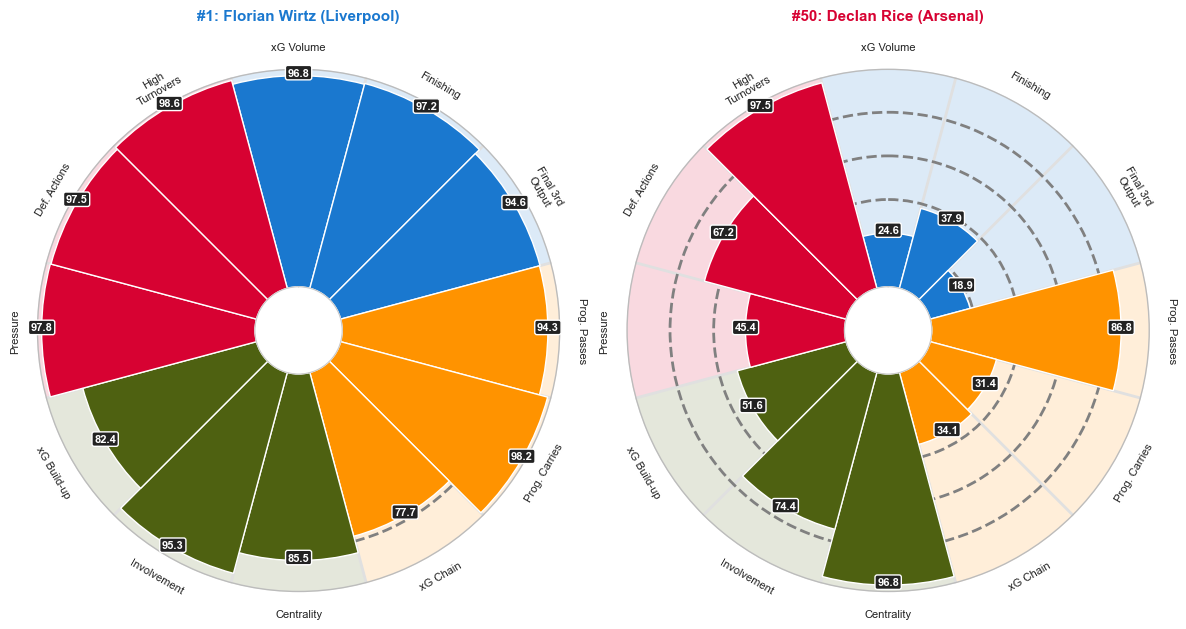

In [ ]:
# Now call your functions using the 'visualization.' prefix
visualization.plot_comparison_pizzas(
    player_scores_final, 
    p1_name=player_scores_final['player'][0], 
    p2_name=player_scores_final['player'][49],
    p1_rank=1, 
    p2_rank=50
)

In [177]:
import visualization
import importlib
importlib.reload(visualization)

<module 'visualization' from '/Users/5soomi/Desktop/school-project/soccer-analytics-capstone-template/analysis/visualization.py'>

In [180]:
visualization.plot_club_distribution(player_scores_final)

NameError: name 'pl' is not defined